In [5]:

import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines as mlines
from matplotlib.animation import FuncAnimation
import numpy as np
import math
import skyfield.api

In [6]:
#calculate orbital period of a satellite [min]
def get_o_period(sat):
    o_period=math.ceil(2*np.pi/sat.model.no_kozai)
    # no_kozai gives the satellite's angular velocity [rad/min]
    return o_period

# calculate satellite orbit in Earth-centered inertial frame 
def generate_orbit(sat, o_period):
    geocentric = sat.at(t_line[:o_period]) # for one circle around the Earth
    x, y, z = geocentric.position.km
    return x, y, z

# give diffrent colors for satellite groups
def set_color(sat):
    if "GPS" in sat.name:
        sat_color = 'b'
    elif ("COSMOS" in sat.name):
        sat_color = 'r'
    elif "BEIDOU" in sat.name:
        sat_color = 'g'
    elif "GALILEO" in sat.name:
        sat_color = 'y'
    elif "QZS" in sat.name:
        sat_color = 'm'
    else:
        sat_color = 'k'
    return sat_color

# obtain the maximum orbit value for the xyz scales
def update_max_val(pos, max_val): 
    for i in range(len(pos)):
        temp = np.max(np.abs(pos[i]))
        max_val = temp if temp > max_val else max_val
    return max_val

# formatting the xyz axes
def set_xyxlim_lbl():
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x,_: f'{int(x/1000):d}'))  
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,_: f'{int(y/1000):d}'))
    ax.zaxis.set_major_formatter(ticker.FuncFormatter(lambda z,_: f'{int(z/1000):d}'))
    ax.set_xlim([-max_val,max_val])
    ax.set_ylim([-max_val,max_val])
    ax.set_zlim([-max_val,max_val])
    ax.set_xlabel("X thousand (km)", size = 10)
    ax.set_ylabel("Y thousand (km)", size = 10)
    ax.set_zlabel("Z thousand (km)", size = 10)

# plot an Earth like central body
def plot_central_body():
    _u, _v = np.mgrid[0:2*np.pi:20j,0:np.pi:10j]
    _x = earth_radius*np.cos(_u)*np.sin(_v)
    _y = earth_radius*np.sin(_u)*np.sin(_v)
    _z = earth_radius*np.cos(_v)
    ax.plot_surface(_x, _y, _z, cmap = 'Blues', alpha=0.5)

def show_legends():
    # classify legends according to satellite categories
    leg_gps = mlines.Line2D([], [], color='b', marker='o', linestyle='None', markersize=3, label='GPS')
    leg_glonass = mlines.Line2D([], [], color='r', marker='o', linestyle='None', markersize=3, label='GLONASS')
    leg_beidou = mlines.Line2D([], [], color='g', marker='o', linestyle='None', markersize=3, label='BEIDOU')
    leg_galileo = mlines.Line2D([], [], color='y', marker='o', linestyle='None', markersize=3, label='GALILEO')
    leg_michibiki = mlines.Line2D([], [], color='m', marker='o', linestyle='None', markersize=3, label='Michibiki')
    leg_others = mlines.Line2D([], [], color='k', marker='o', linestyle='None', markersize=3, label='Others')
    # set legend markers
    ax.legend(bbox_to_anchor=(0.15, 1.05), loc='upper right', 
              handles=[leg_gps, leg_glonass, leg_beidou, leg_galileo, leg_michibiki, leg_others],fontsize=10)

In [7]:
def anim_func(i):
    ax.cla()
    plot_central_body()
    
    step=delta_t
    
    for j in range(len(sats)):
        # draw each satellite's orbit for its one orbital period
        plt.plot(sat_positions[j][0][:sat_periods[j]], sat_positions[j][1][:sat_periods[j]], sat_positions[j][2][:sat_periods[j]], color=sat_colors[j], lw=0.3, label = None)
        # show the current position of each satellite in a colored small circle
        plt.plot(sat_positions[j][0][i*step], sat_positions[j][1][i*step], sat_positions[j][2][i*step], color=sat_colors[j], marker='o', markersize=3)

    show_legends()
    set_xyxlim_lbl()
    ax.set_aspect('equal')
    fig.suptitle('Global Navigation Satellite Systems (GNSS)', size=16)
    ax.set_title(t_line.utc_strftime()[i*step])

[#################################] 100% gnss.txt
[#################################] 100% gnss.txt


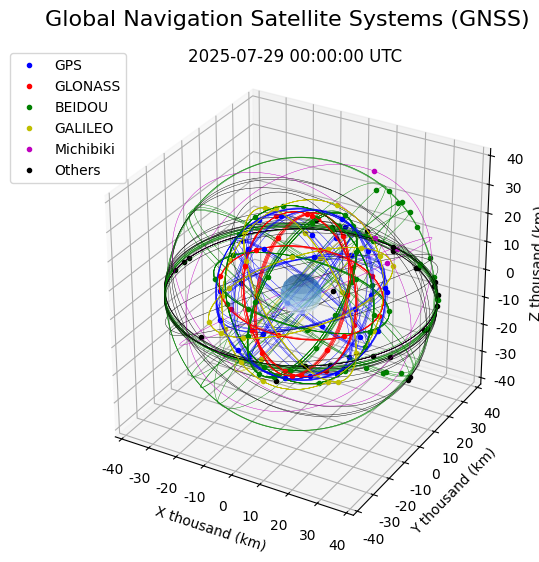

In [8]:
earth_radius = 6378.137 # [km]

sat_positions=[] #store each satellite's positions (x,y,z) in Earth-centred inertial frame
sat_periods = [] #store each satellite's orbital period
sat_colors=[] #give colors for satellite groups for plotting

max_val = 0.0 # max orbital value to set the xyz axes scale

# set a starting time point for orbit calculation
today = datetime.date.today()
year = today.year
month = today.month
day = today.day
hour = 0
#animation time length to capture satellite movement
t_len =24*60 #set at 24 hours to allow GEO satellites complete full go-aroud (others make several rounds)
delta_t = 5 #plot every 5th element in the timeline, 5min interval for this case 
anim_frm = math.ceil(t_len/delta_t) # total number of animation frames
# create timescale object captring the timeline (24*60 min)
ts = skyfield.api.load.timescale() 
t_line = ts.utc(year, month, day, hour, range(0, t_len))


# create GNSS satellite objects downloading the TLE data from celestrak.com
url = "https://celestrak.org/NORAD/elements/gnss.txt"
sats = skyfield.api.load.tle_file(url, reload=True)

# or directly from the TLE data from the celestrak website:
sats = skyfield.api.load.tle_file(url, reload=True)

# for each satellite object calculate its orbit
for sat in sats:
    o_period = get_o_period(sat)
    sat_periods.append(o_period)
    x, y, z = generate_orbit(sat,t_len)
    pos = [x, y, z]
    max_val=update_max_val(pos, max_val) 
    sat_positions.append(pos)
    sat_colors.append(set_color(sat))

#3d animation
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection ='3d')

ani = FuncAnimation(fig, anim_func, interval = 10, frames=anim_frm) 
# save the animation in a gif format file
ani.save('GNSS_ani.gif', writer='pillow', fps=20)